In [1]:
###-----------------
### Import libraries
###-----------------
from pathlib import Path  # Import Path for file system path operations and management
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split  # Import function to split dataset into training and testing subsets
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             f1_score)  # Import function to calculate various metric


In [2]:
###------------------
### Global Parameters
###------------------

# Directories
#inpDir = '../../input' 
inpDir = Path('..') / '..' / 'input'
# outDir = '../output'
outDir = Path('..') / 'output'


RANDOM_STATE = 24 
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
rng = np.random.default_rng(seed = RANDOM_STATE)

TEST_SIZE  = 0.2 # Size of test data
NOISE = 0.2
EPOCHS =5000
ALPHA = 0.1
N_SAMPLE  = 1000


# Parameters for plotting
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

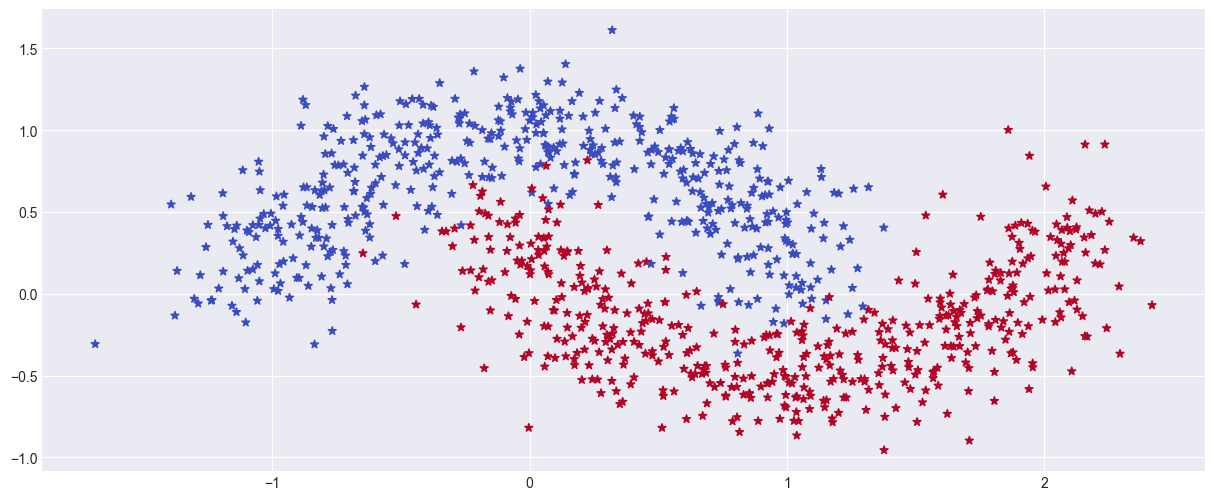

In [3]:
X,y  = make_moons(n_samples=N_SAMPLE,noise=NOISE,random_state=RANDOM_STATE,shuffle=True)


plt.scatter(X[:,0],X[:,1],c=y,cmap= CMAP,marker='*')

In [4]:
def fn_plot_decision_boundary(X: np.ndarray,y: np.ndarray, model:dict, predict,dimension,alpha):
    """
    Plots the decision boundary for a classification model along with the data points.
    
    Args:
        X (np.ndarray): Input feature matrix with shape (n_samples, 3)
        wts (np.ndarray): Weights matrix
        pred_function: Function to predict using weights and datapoints
    """
    
    # Initialize the figure with specified dimensions
    fig, ax = plt.subplots( figsize=(8, 5) )
    
    # Small increment value to create a fine grid for smooth decision boundary
    dm = 0.05
    padding = 2 * dm
    
    # Calculate the range for x-axis (first feature) with padding
    x_min, x_max = X[:, 0].min() - padding, X[:, 0].max() + padding
    
    # Calculate the range for y-axis (second feature) with padding  
    y_min, y_max = X[:, 1].min() - padding, X[:, 1].max() + padding
    
    # Create a mesh grid covering the entire feature space
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))
    
    # Flatten the mesh grid arrays and stack them column-wise to create coordinate pairs
    XX = np.c_[xx.ravel(), yy.ravel()] # Resulting shape: (n_points, 2)

    # Add a column of ones to the coordinate array for the bias term
    
    # List to collect predictions for each point in the mesh grid
    y_pred = predict(model,XX)
    Z = np.array(y_pred).reshape(xx.shape)
    # Create filled contour plot showing the decision regions
    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    
    # Scatter plot of the actual data points, colored by their true class labels
    ax.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k', cmap=plt.cm.bwr)
    
    # Set plot title and axis labels
    ax.set_title(f'Decision Boundary for learning rate : {alpha} , dimension : {dimension}')
    ax.set_xlabel('A')  
    ax.set_ylabel('B') 
    
    # Display the final plot
    plt.show()

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=TEST_SIZE,random_state=RANDOM_STATE)
y_train = y_train.reshape(-1,1)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((800, 2), (200, 2), (800, 1), (200,))

In [6]:
data_df = pd.DataFrame(X,columns=['A','B'])
data_df['target'] = y
data_df

A         B  target
0    0.906340  0.902676       0
1   -1.115368  0.755793       0
2    1.887692  0.417597       1
3   -0.933450 -0.022999       0
4   -0.968729  0.063963       0
..        ...       ...     ...
995 -1.005476  0.490728       0
996 -0.484457  0.846436       0
997  0.284856  0.793560       0
998  1.712514 -0.177786       1
999 -0.958774  0.538358       0

[1000 rows x 3 columns]

In [7]:
data_train,data_test  = data_df.to_numpy()[:900],data_df.to_numpy()[900:]
data_train.shape,data_test.shape

((900, 3), (100, 3))

In [8]:
def fn_sigmoid(z: np.ndarray) -> float:
    return 1 / (1 + np.exp(-z))

In [9]:
def fn_active(z):
    return np.tanh(z)
def fn_active_prime(z):
    return 1.0 - np.tanh(z)**2

In [10]:
fn_active(np.asarray([[-1.0,0,1.0]]))

array([[-0.76159416,  0.        ,  0.76159416]])

In [11]:
		
def predict(model, X):
    W1 = model['W1']
    W2 = model['W2']
    b1 = model['b1']
    b2 = model['b2']
    
    #Forward propgation - 
    z1 = X.dot(W1) + b1 #aggregation
    a1 = fn_active(z1) #activation
    z2 = a1.dot(W2) + b2
    a2 = fn_sigmoid(z2)
    return  a2 >= 0.5 


In [12]:
		
def calculate_loss(model, X,y):
    W1 = model['W1']
    W2 = model['W2']
    b1 = model['b1']
    b2 = model['b2']
    m = X.shape[0]
    #Forward propgation - 
    z1 = X.dot(W1) + b1 #aggregation
    a1 = fn_active(z1) #activation
    z2 = a1.dot(W2) + b2
    a2 = fn_sigmoid(z2)
    data_loss = -(y * np.log(a2) + (1-y)*np.log(1-a2)).sum()
    return data_loss/m

In [13]:
    
loss_hist = {}

def build_model(nn_hdim,X,y,alpha,n_epoch):
    m,nn_input_dim = X.shape
    nn_output_dim = y.shape[1]
    W1 = rng.random((nn_input_dim,nn_hdim)) / np.sqrt(nn_input_dim) #initialize random weights 
    W2 = rng.random((nn_hdim,nn_output_dim)) / np.sqrt(nn_hdim) #initialize random weights 
    b1 = np.zeros((1,nn_hdim))
    b2 = np.zeros((1,nn_output_dim))

    loss,epoch = [],[]
    global loss_hist
    loss_hist = {}
    
    for i in range(n_epoch):
        #Forward propgation - 
        z1 = X.dot(W1) + b1 #aggregation
        a1 = fn_active(z1) #activation

        z2 = a1.dot(W2) + b2
        a2 = fn_sigmoid(z2)
        
        
        #Back propogation - 
        
        #layer 2
        dz2 = a2 - y
        assert(z2.shape == dz2.shape), f'Shape z2, {z2.shape} , {dz2.shape}'
        dW2 = (a1.T).dot(dz2)
        assert(W2.shape == dW2.shape), f'Shape z2, {W2.shape} , {dW2.shape}'
        db2 = np.sum(dz2,axis = 0,keepdims=True)
        assert(b2.shape == db2.shape), f'Shape z2, {b2.shape} , {db2.shape}'
        da1 = dz2.dot(W2.T)
        assert(a1.shape == da1.shape), f'Shape z2, {a1.shape} , {da1.shape}'

        #layer 1
        dz1 = da1 * fn_active_prime(z1)
        assert(z1.shape == dz1.shape), f'Shape z2, {z1.shape} , {dz1.shape}'
        dW1 = (X.T).dot(dz1)
        assert(W1.shape == dW1.shape), f'Shape z2, {W1.shape} , {dW1.shape}'
        db1 = np.sum(dz1,axis = 0,keepdims=True)
        assert(b1.shape == db1.shape), f'Shape z2, {b1.shape} , {db1.shape}'

        #upldating wieghts and bias for optimization
        W1 = W1 - alpha*dW1/m
        W2 = W2 - alpha*dW2/m
        b1 = b1 - alpha*db1/m
        b2 = b2 - alpha*db2/m

        
        model = {'W1' : W1,'W2' : W2, 'b1' : b1, 'b2' : b2}
        if  i%100 == 0:
            curr_loss = calculate_loss(model,X,y) #calculating loss after every 100 epoch
            epoch.append(i)
            loss.append(curr_loss)
            print(f'epoch - {i} : Loss - {curr_loss}')
    loss_hist['epoch'] = epoch 
    loss_hist['loss'] = loss
    return model

In [14]:
model = build_model(4,X_train,y_train,ALPHA,EPOCHS) #TRAIN MODEL
# y_train = y_train.reshape(-1,1)
# y_train.shape
model

epoch - 0 : Loss - 0.7188583199311445
epoch - 100 : Loss - 0.4481913910312672
epoch - 200 : Loss - 0.3347788969472061
epoch - 300 : Loss - 0.30420703375788577
epoch - 400 : Loss - 0.29733373643051847
epoch - 500 : Loss - 0.2955393911598401
epoch - 600 : Loss - 0.2948276507678817
epoch - 700 : Loss - 0.2943520451816729
epoch - 800 : Loss - 0.2939131155267854
epoch - 900 : Loss - 0.29344808921822363
epoch - 1000 : Loss - 0.2929160776002122
epoch - 1100 : Loss - 0.2922657911922088
epoch - 1200 : Loss - 0.2914175049017394
epoch - 1300 : Loss - 0.2902419691070806
epoch - 1400 : Loss - 0.28853225909922287
epoch - 1500 : Loss - 0.28597664042912946
epoch - 1600 : Loss - 0.2821647491680419
epoch - 1700 : Loss - 0.2766842442750273
epoch - 1800 : Loss - 0.26932745032858885
epoch - 1900 : Loss - 0.26028677186363763
epoch - 2000 : Loss - 0.25014022083707965
epoch - 2100 : Loss - 0.2396101101481649
epoch - 2200 : Loss - 0.22930185879092582
epoch - 2300 : Loss - 0.21958935878195987
epoch - 2400 : Los

{'W1': array([[ 0.72006091,  1.1165229 ,  3.86006224,  1.74971211],
        [-0.67815043, -0.8517681 ,  1.95460416, -0.96028989]]),
 'W2': array([[ 3.24381303],
        [ 3.64421311],
        [-5.05574865],
        [ 4.24902361]]),
 'b1': array([[-0.56924668, -1.33272086, -2.10793816,  1.14609664]]),
 'b2': array([[0.10059412]])}

In [15]:
loss_df = pd.DataFrame(loss_hist)   #LOSS DATAFRAME 
loss_df 

epoch      loss
0       0  0.718858
1     100  0.448191
2     200  0.334779
3     300  0.304207
4     400  0.297334
5     500  0.295539
6     600  0.294828
7     700  0.294352
8     800  0.293913
9     900  0.293448
10   1000  0.292916
11   1100  0.292266
12   1200  0.291418
13   1300  0.290242
14   1400  0.288532
15   1500  0.285977
16   1600  0.282165
17   1700  0.276684
18   1800  0.269327
19   1900  0.260287
20   2000  0.250140
21   2100  0.239610
22   2200  0.229302
23   2300  0.219589
24   2400  0.210637
25   2500  0.202472
26   2600  0.195052
27   2700  0.188303
28   2800  0.182149
29   2900  0.176514
30   3000  0.171327
31   3100  0.166528
32   3200  0.162056
33   3300  0.157858
34   3400  0.153875
35   3500  0.150049
36   3600  0.146309
37   3700  0.142580
38   3800  0.138776
39   3900  0.134822
40   4000  0.130677
41   4100  0.126370
42   4200  0.121997
43   4300  0.117691
44   4400  0.113569
45   4500  0.109706
46   4600  0.106134
47   4700  0.102856
48   4800  0.099859
49   4900  0.097123

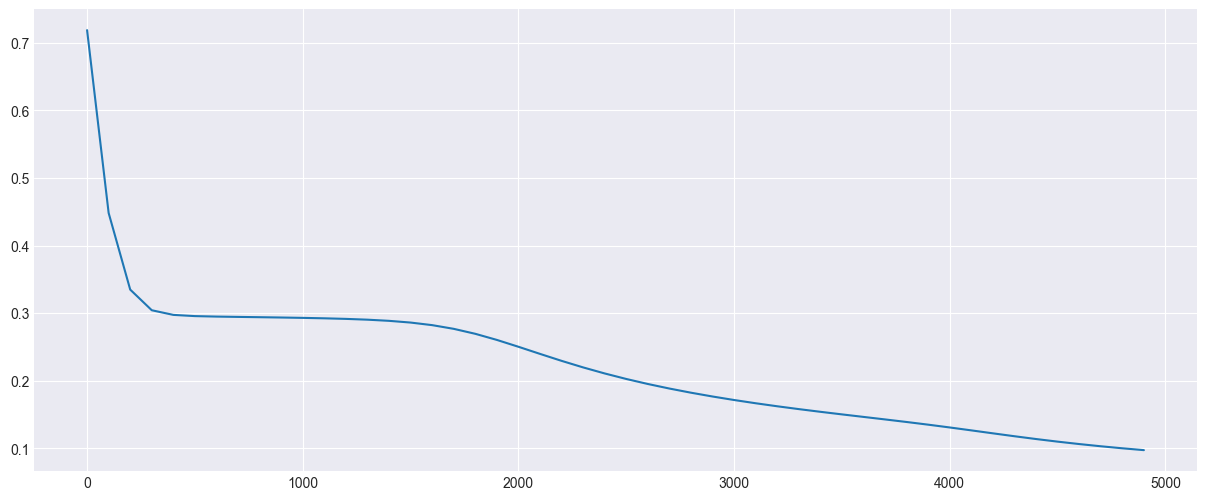

In [16]:
plt.plot(loss_df['epoch'],loss_hist['loss'])

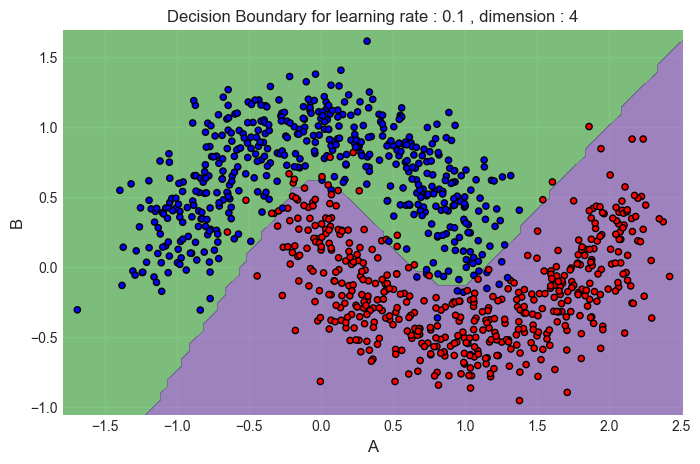

In [17]:
fn_plot_decision_boundary(X,y,model,predict,4,ALPHA)

<h1>Comparing for Different dimensions and learning rate</h1>

In [18]:
dims = [1,2,3,4,5,10,20] #dimensions 
lr = [0.01,0.1,0.2,0.5,1] #learning rates 

In [19]:

#building models for different dimensions and for different learning rates  
y_test_reshape = y_test.reshape(-1,1) #reshaphing to compare with predicted values
y_train_reshape = y_train.reshape(-1,1) #reshaphing to compare with predicted values
score = [] #array to score accuracy score for different matrix
for dim in dims:
    for l in lr:
        model = build_model(dim,X_train,y_train,l,EPOCHS)  #for epoch = 5000
        y_pred_tr = predict(model,X_train) #prediction for train set
        y_pred_ts = predict(model,X_test) #prediction for test set
        test_acc = accuracy_score(y_test_reshape,y_pred_ts) # Test accuracy
        train_acc = accuracy_score(y_train_reshape,y_pred_tr) #traub accuracy
        score.append([dim,l,train_acc,test_acc])

epoch - 0 : Loss - 0.6189475206104255
epoch - 100 : Loss - 0.5915001706838167
epoch - 200 : Loss - 0.5645885189981968
epoch - 300 : Loss - 0.5386192409598083
epoch - 400 : Loss - 0.514096638265527
epoch - 500 : Loss - 0.49135548875789126
epoch - 600 : Loss - 0.47054220590368856
epoch - 700 : Loss - 0.45166959062532974
epoch - 800 : Loss - 0.43467183455884983
epoch - 900 : Loss - 0.41944238687585644
epoch - 1000 : Loss - 0.4058562397210349
epoch - 1100 : Loss - 0.39378188857883517
epoch - 1200 : Loss - 0.3830874753072224
epoch - 1300 : Loss - 0.37364404691226155
epoch - 1400 : Loss - 0.36532751500016425
epoch - 1500 : Loss - 0.3580200211806279
epoch - 1600 : Loss - 0.3516109534090333
epoch - 1700 : Loss - 0.34599767217740895
epoch - 1800 : Loss - 0.34108595735049513
epoch - 1900 : Loss - 0.33679018950782036
epoch - 2000 : Loss - 0.33303329281787597
epoch - 2100 : Loss - 0.32974647618380054
epoch - 2200 : Loss - 0.32686881409277224
epoch - 2300 : Loss - 0.3243467097700936
epoch - 2400 : 

In [20]:

#Storing accuracy scores in pandas dataframe
result = pd.DataFrame(score,columns=['Dimensions', 'Learning Rate','Training Accuracy','Testing Accuracy']) 

In [21]:

result.sort_values(['Testing Accuracy','Training Accuracy'],ascending=[False,False])

Dimensions  Learning Rate  Training Accuracy  Testing Accuracy
34          20           1.00            0.98125             0.970
33          20           0.50            0.98000             0.970
23           5           0.50            0.98250             0.965
24           5           1.00            0.98250             0.965
28          10           0.50            0.98250             0.965
29          10           1.00            0.98250             0.965
13           3           0.50            0.98125             0.965
14           3           1.00            0.98125             0.965
18           4           0.50            0.98125             0.965
19           4           1.00            0.98125             0.965
32          20           0.20            0.98000             0.965
26          10           0.10            0.97000             0.965
22           5           0.20            0.98250             0.960
17           4           0.20            0.98125             0.960
27          10           0.20            0.97875             0.960
31          20           0.10            0.97000             0.960
4            1           1.00            0.86875             0.870
9            2           1.00            0.87250             0.865
25          10           0.01            0.87875             0.860
30          20           0.01            0.87250             0.860
8            2           0.50            0.86875             0.860
15           4           0.01            0.87500             0.855
0            1           0.01            0.87375             0.855
5            2           0.01            0.87375             0.855
7            2           0.20            0.87375             0.855
20           5           0.01            0.87375             0.855
1            1           0.10            0.87250             0.855
2            1           0.20            0.87250             0.855
6            2           0.10            0.87250             0.855
10           3           0.01            0.87250             0.855
11           3           0.10            0.87250             0.855
12           3           0.20            0.87250             0.855
16           4           0.10            0.87250             0.855
21           5           0.10            0.87250             0.855
3            1           0.50            0.87875             0.850

<h1>Decision boundaries for different numbers of dimensions and different learning rates</h1>

In [22]:
models = [] #array to different models made up of different dimesion  and learning rate
dims = [1,2,3,4,5,10,20] #dimensions
lr = [0.01,0.1,0.2,0.5,1] #learning rates
for dim in dims:
    for l in lr:
        models.append([build_model(dim,X_train,y_train,l,1001),dim,l]) #for epoch = 1001

epoch - 0 : Loss - 0.688385160747436
epoch - 100 : Loss - 0.6837582224304104
epoch - 200 : Loss - 0.677983542695355
epoch - 300 : Loss - 0.6704315970359065
epoch - 400 : Loss - 0.6605373973639255
epoch - 500 : Loss - 0.6478647505547326
epoch - 600 : Loss - 0.6322164808782661
epoch - 700 : Loss - 0.6137430781071207
epoch - 800 : Loss - 0.5929760321277712
epoch - 900 : Loss - 0.5707335668561815
epoch - 1000 : Loss - 0.5479277519806242
epoch - 0 : Loss - 0.6992216243628755
epoch - 100 : Loss - 0.5126934871810219
epoch - 200 : Loss - 0.3627751379161178
epoch - 300 : Loss - 0.3217482974932351
epoch - 400 : Loss - 0.3102661838757134
epoch - 500 : Loss - 0.3063288019621781
epoch - 600 : Loss - 0.30451354319004664
epoch - 700 : Loss - 0.303369617857147
epoch - 800 : Loss - 0.30247559132741797
epoch - 900 : Loss - 0.3017042682161658
epoch - 1000 : Loss - 0.30101567803725315
epoch - 0 : Loss - 0.6800456479849757
epoch - 100 : Loss - 0.3694509539654881
epoch - 200 : Loss - 0.31058821102212675
epo

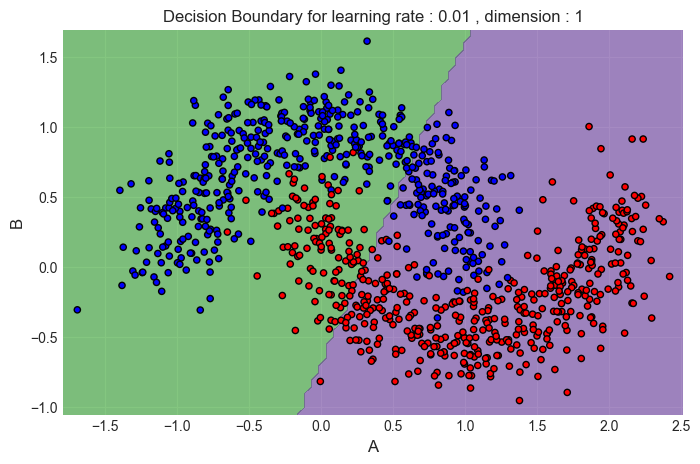

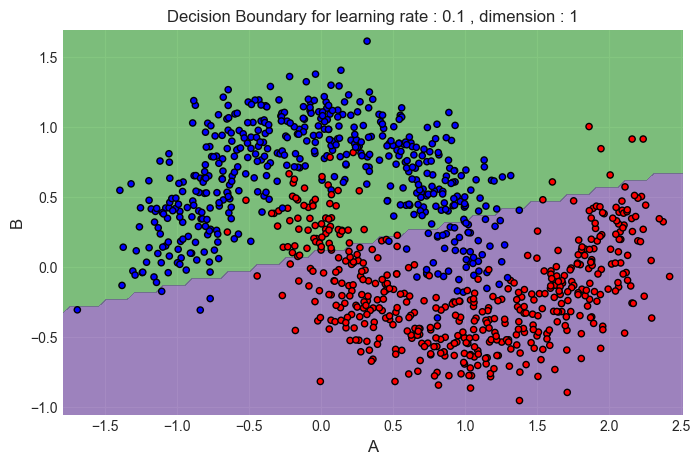

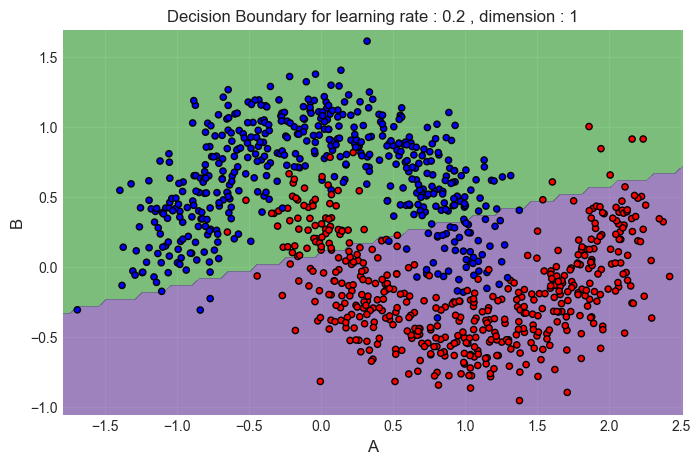

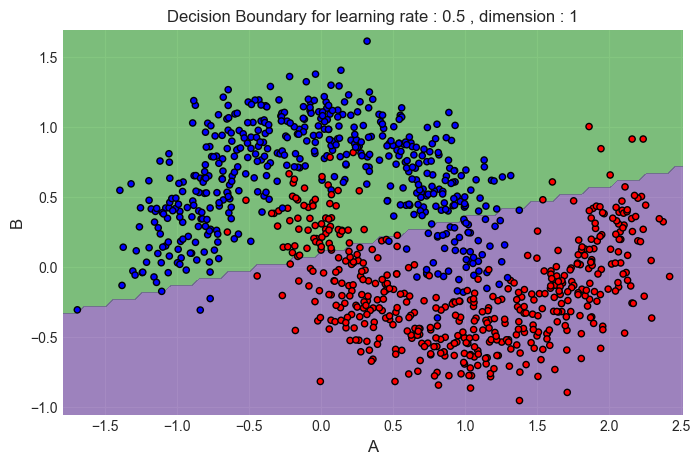

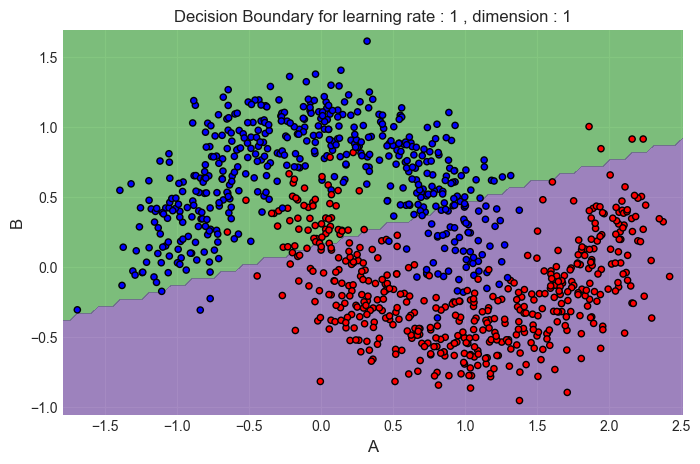

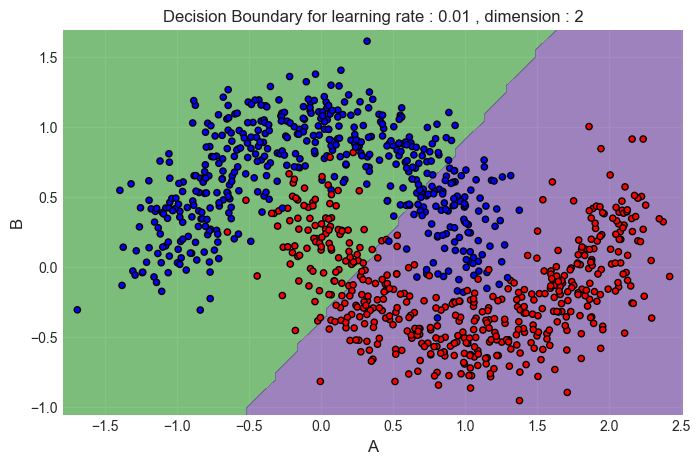

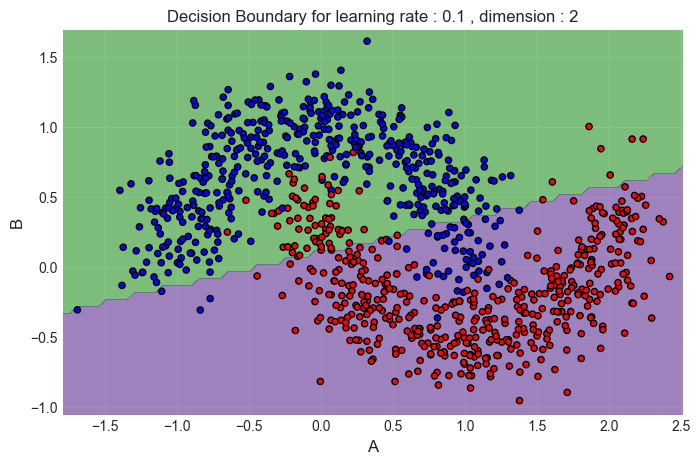

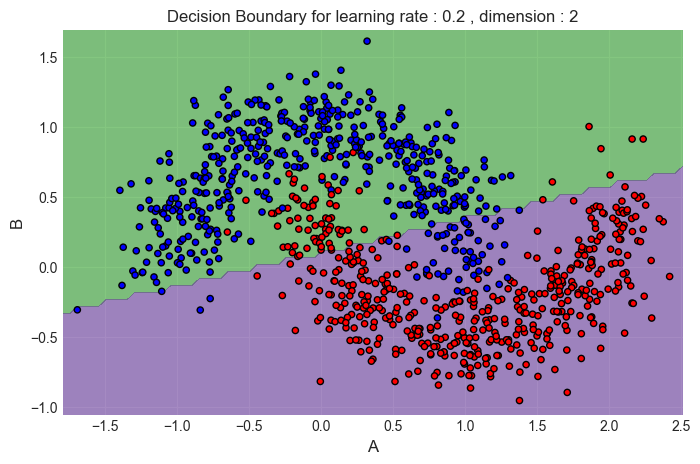

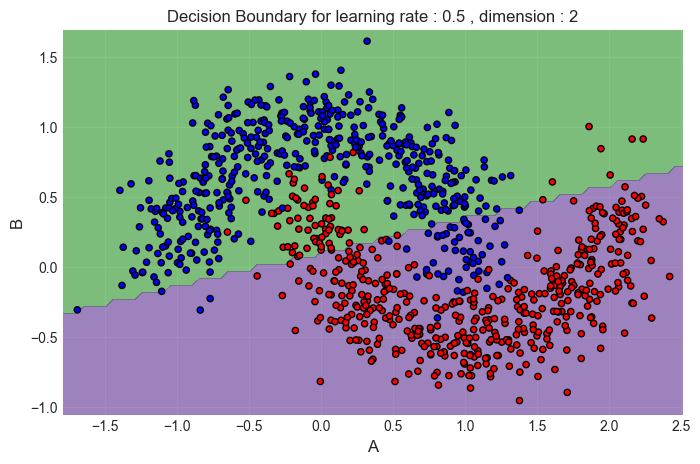

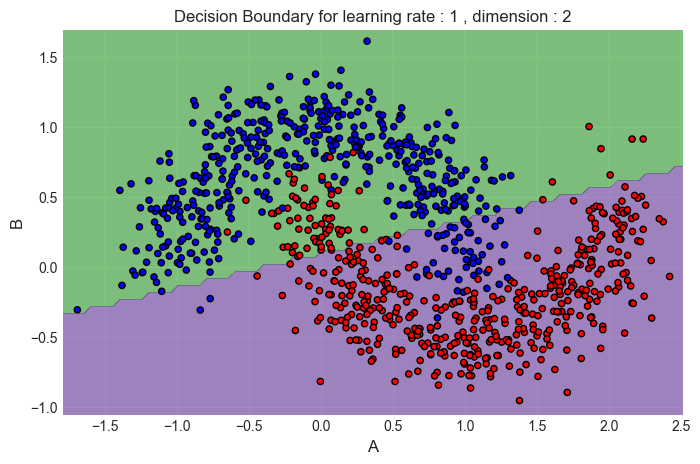

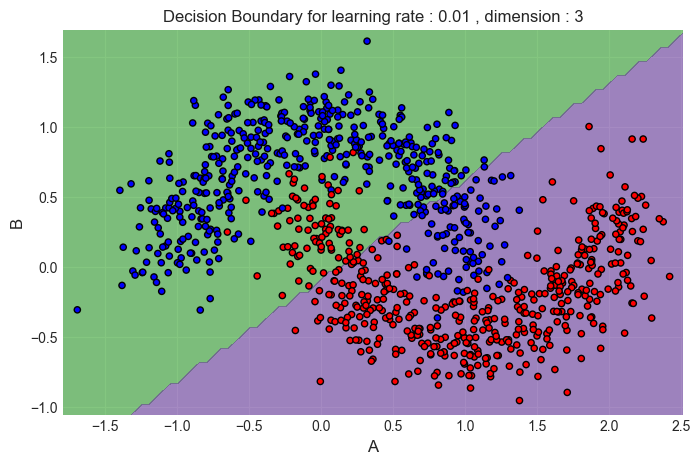

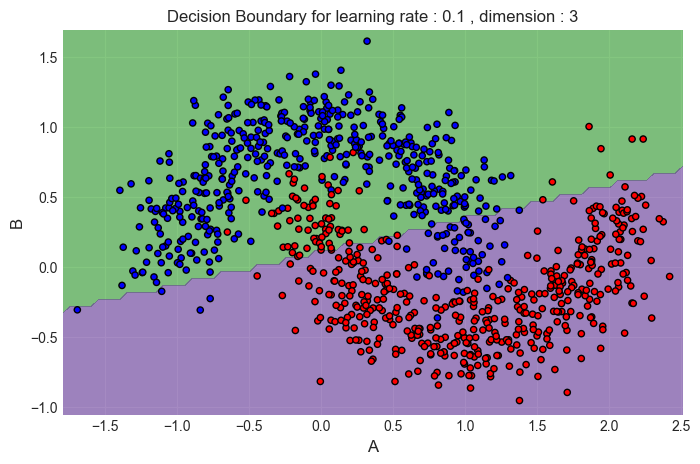

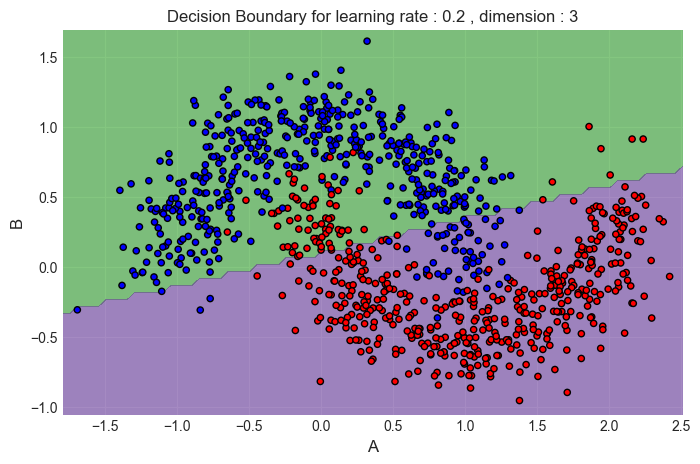

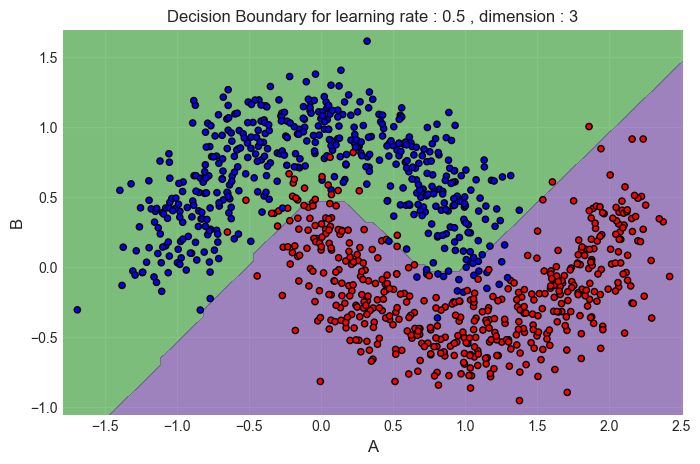

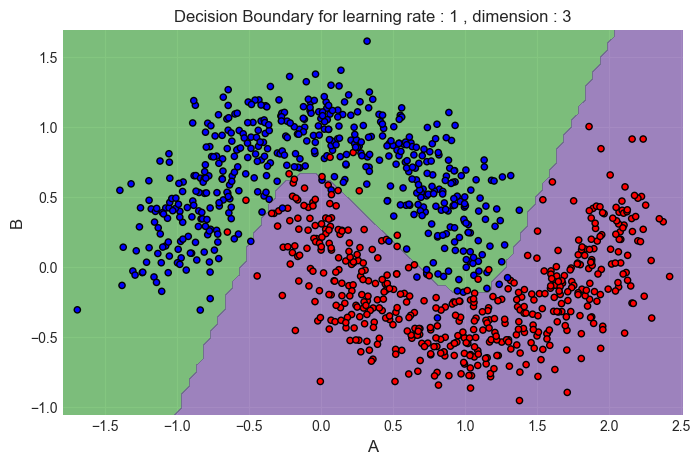

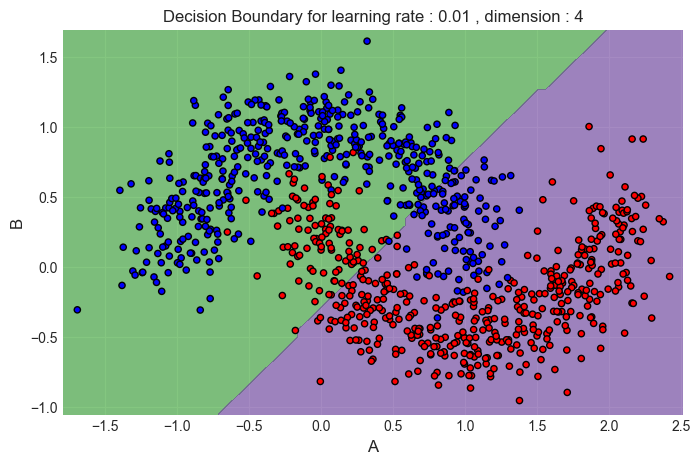

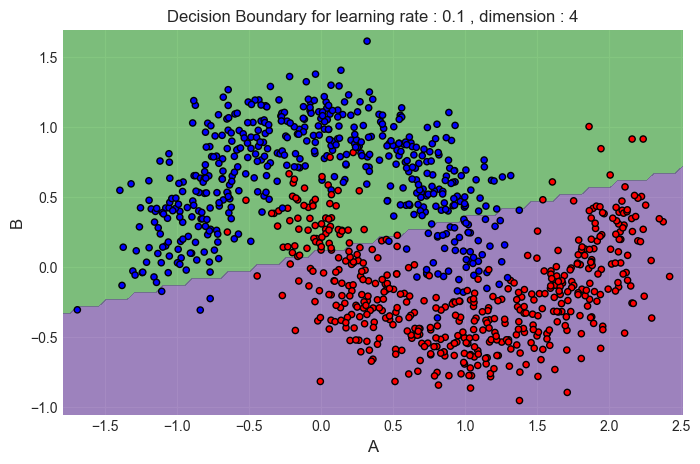

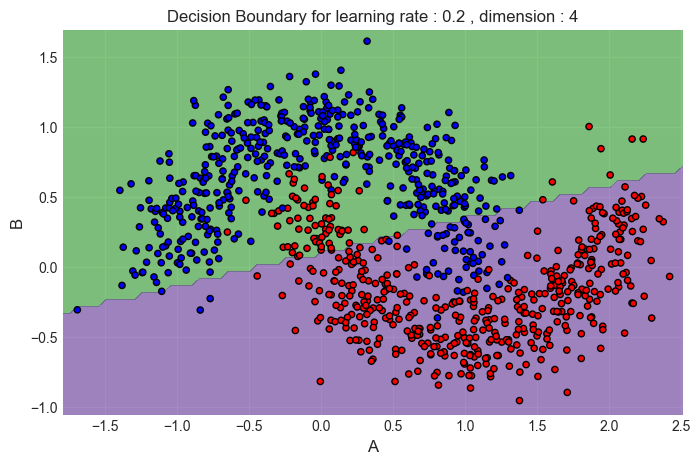

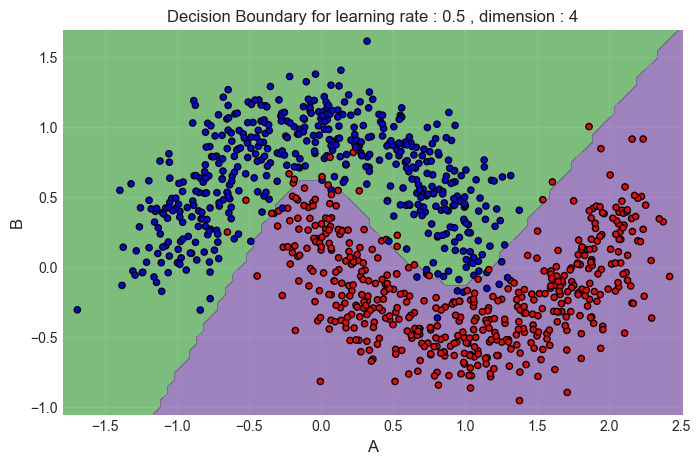

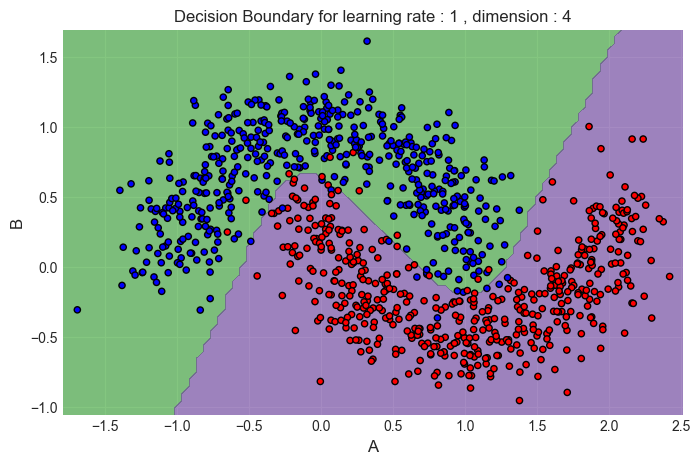

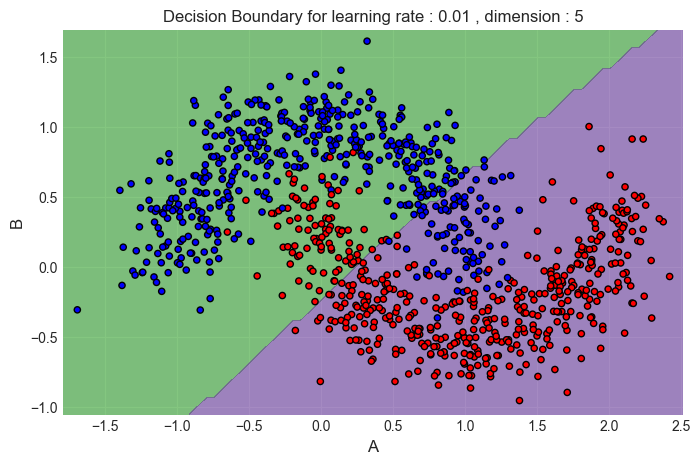

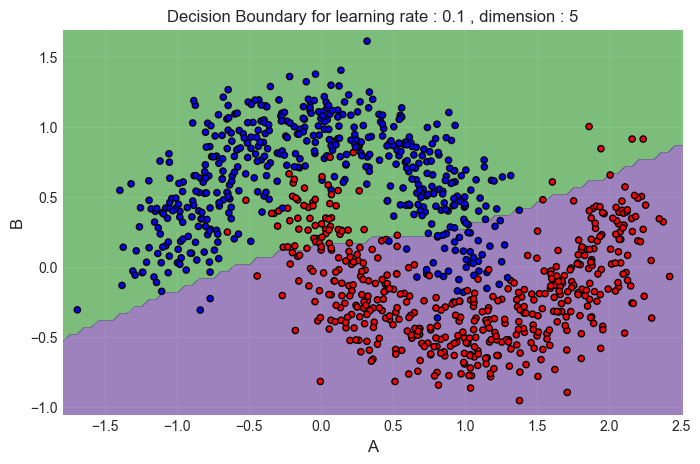

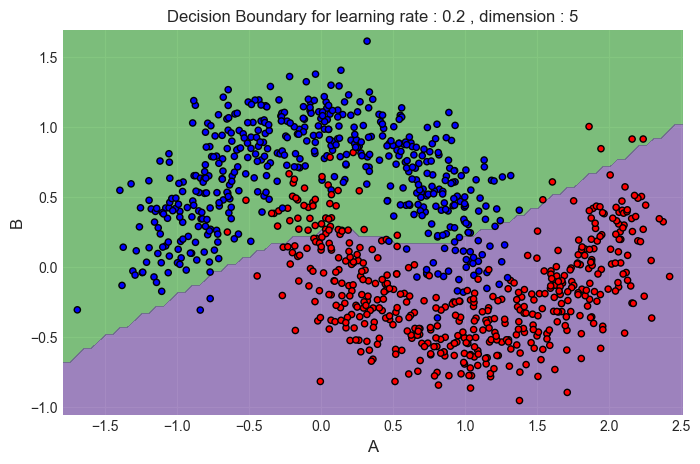

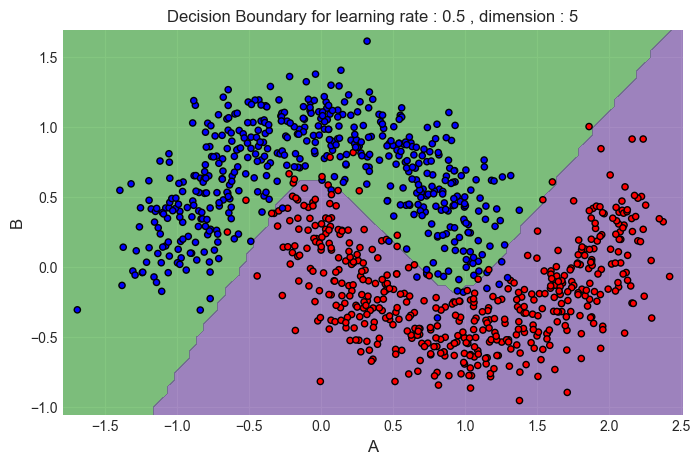

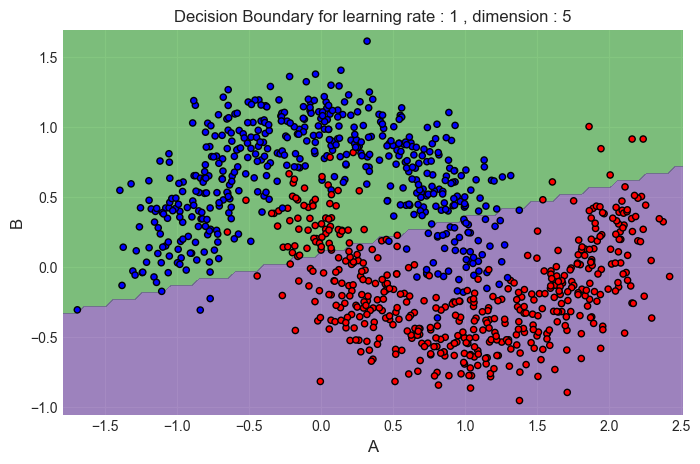

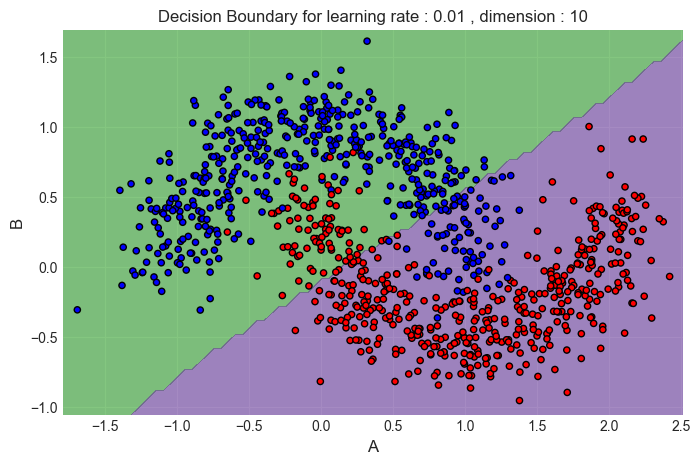

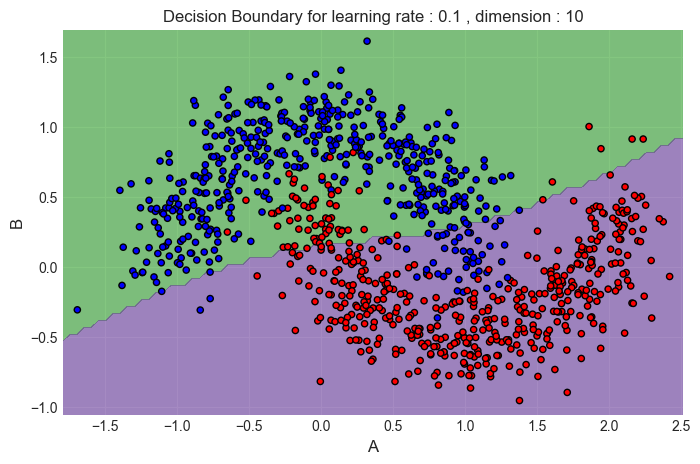

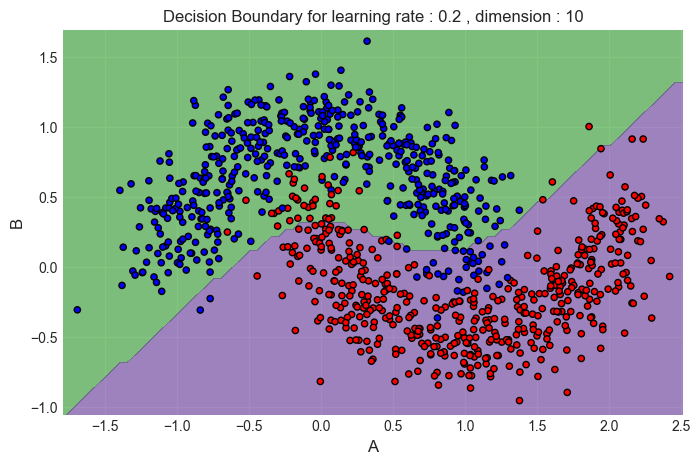

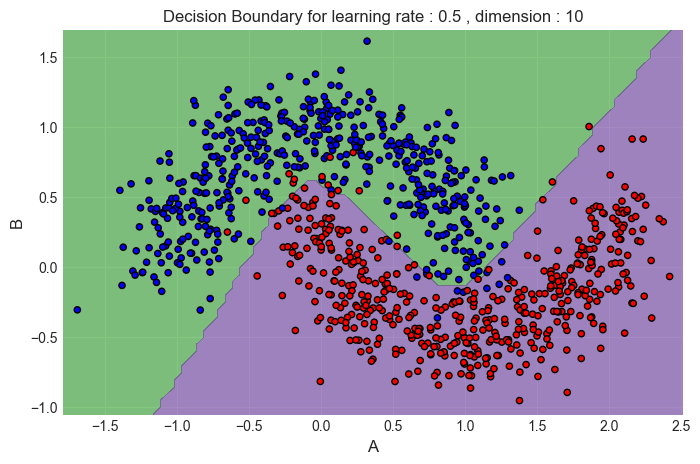

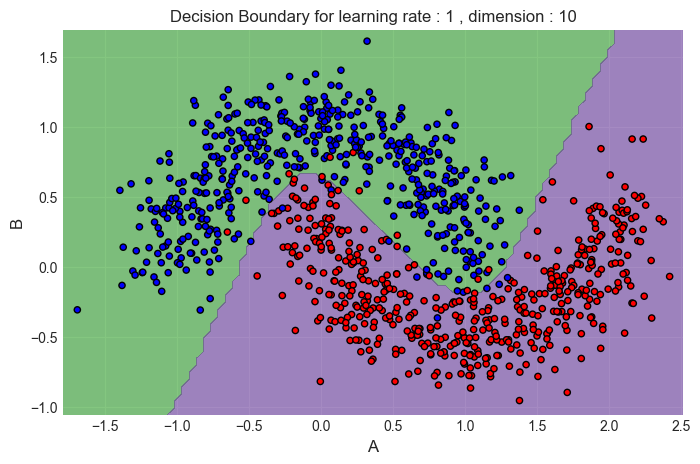

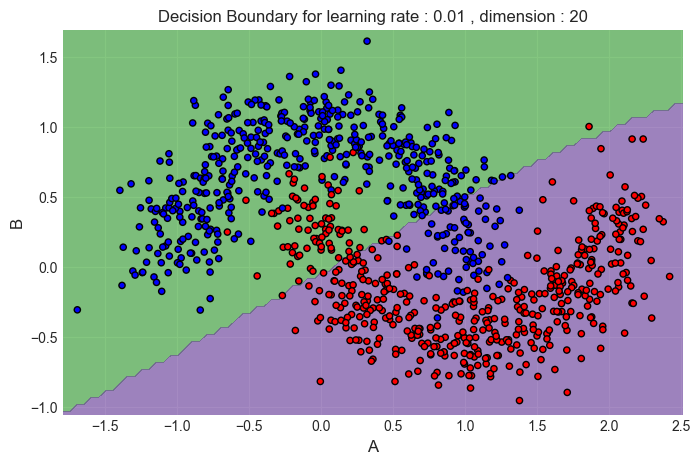

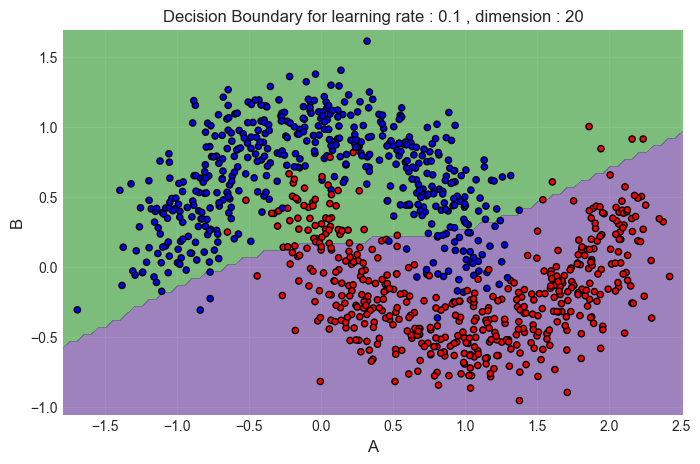

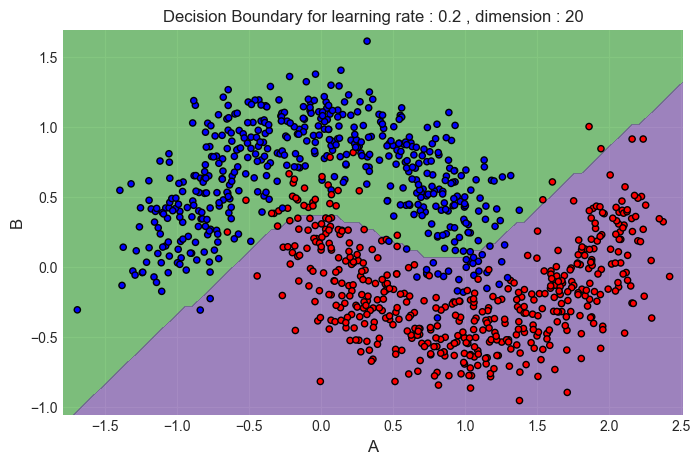

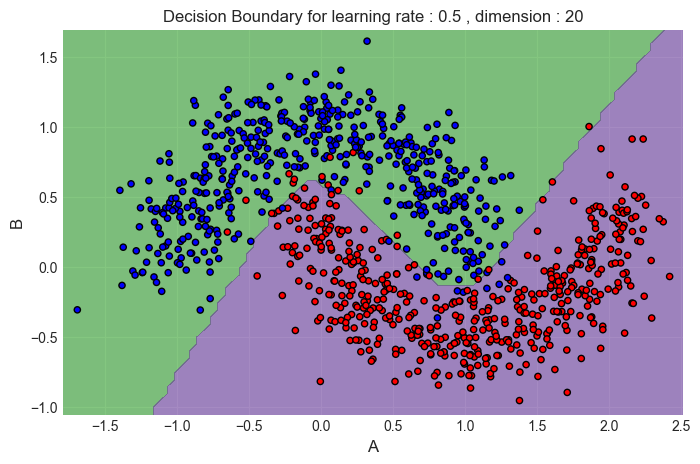

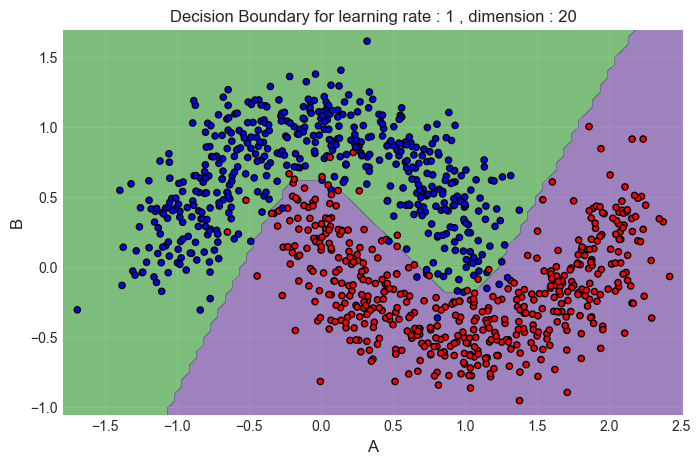

In [23]:
for i in models:
    fn_plot_decision_boundary(X,y,i[0],predict,i[1],i[2]) #visulazing descion tree